In [2]:
import os
import numpy as np
import pandas as pd
import pysam
import multiprocessing
import matplotlib.pyplot as plt
from pydeseq2.preprocessing import deseq2_norm
import seaborn as sns
import csv
from os.path import join
from scipy.stats import pearsonr
from sklearn.metrics import precision_score, recall_score
import json
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc, average_precision_score
import matplotlib.patches as patches

In [3]:
def TPM_function(bambu_rpk):
    
    summation = sum(bambu_rpk)
    
    if summation > 0: 
        bambu_ScaleFactor = sum(bambu_rpk) / 1e6
        bambu_tpm = bambu_rpk / bambu_ScaleFactor
        return bambu_tpm
    else:
        return bambu_rpk

In [5]:
def spearman_count(short_read_path, short_read_infRV, quant_dir, short_read_flag, majorTxp, file_type, compare_type, mean_val):
    
    #dataset
    directRNA_txp = 'Hct116_31'  
    d = {'Hct116_32': 'directcDNA', 'Hct116_31': 'directRNA'} 
    
    # read ground truth
    if short_read_flag:
        t = pd.read_csv(short_read_path, sep="\t")
        t.columns = t.columns.str.upper()
        t.rename(columns={t.columns[3]: "SHORT_READ"}, inplace=True)
        
        #======================================================================================================
        #read in all synthetic transcripts in Hct116 dataset
        synthetic = pd.read_csv("/fs/cbcb-scratch/zzare/exp_quant/Hct116_quant/synthetic_txp_names.csv", sep="\t", header=None)
        synthetic.columns = ["NAME"]
        #======================================================================================================
        
        #choose the transcripts with the lower infRV values (threshold valus is the mean(infRVs))
        infRV = pd.read_csv(short_read_infRV, sep="\t")
        #-----------------------------------------------------------
        #infRV_synthetic = infRV[infRV["Txp"].isin(synthetic["NAME"])]
        #-----------------------------------------------------------
        infRV = infRV[~infRV["Txp"].isin(synthetic["NAME"])]
        
        if mean_val == "nonZero_mean":
            infRV = infRV[infRV["mean"] != 0]

        if compare_type == "0.1":
            mean_value = 0.1
        elif compare_type == "0.5":
            mean_value = 0.5
        elif compare_type == "all":
            mean_value = max(infRV["infRV"])
        infRV_txps = infRV[infRV["infRV"] <= mean_value]
        
        #-----------------------------------------------------------
        #infRV_txps = pd.concat([infRV_txps, infRV_synthetic], axis=0)
        #-----------------------------------------------------------
        t = pd.merge(infRV_txps, t, left_on="Txp", right_on="NAME", how="left")

        print("is there nan value in NAME: ", t['NAME'].isna().any())
        
        t.replace(np.nan, 0, inplace=True)
        t['SHORT_READ'] = TPM_function(t['SHORT_READ'])

        how_value = "right"
    else:
        t = pd.read_excel(short_read_path, sheet_name="Sheet1")
        t = t.iloc[1:, 0:2]
        t.columns = ["NAME", "SHORT_READ"]
        t["SHORT_READ"] = pd.to_numeric(t["SHORT_READ"], errors='coerce')
        
        t.replace(np.nan, 0, inplace=True)
        t['SHORT_READ'] = TPM_function(t['SHORT_READ'])
        
        how_value = "right"
    
    
        
    #read major transcripts
    if majorTxp:
        #read major transcripts file
        t_major = pd.read_excel("/fs/cbcb-scratch/zzare/exp_quant/Hct116_quant/media-3.xlsx", sheet_name="SummaryWithinCellLine")
        t_major = t_major[t_major['cellLine'] == directRNA_txp.split('_')[0]]
        unique_gene_txp_pairs = set(zip(t_major['gene_name'], t_major['txMajor']))
        unique_gene_txp_df = pd.DataFrame(list(unique_gene_txp_pairs), columns=['GENEID', 'TXNAME'])


    #read in the count files   
    oarfish_align_cov = {k: {} for k in d}
    oarfish_align_nocov = {k: {} for k in d}
    NanoCount = {k: {} for k in d}
    bambu = {k: {} for k in d}
    kallisto = {k: {} for k in d}
    isoquant = {k: {} for k in d}
    espresso = {k: {} for k in d}
    transigner = {k: {} for k in d}
    
    for k, v in d.items():
        if file_type == "No_shr":
            oarfish_align_cov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant/{v}/{k}/out_cov.quant", sep="\t")
            oarfish_align_nocov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant/{v}/{k}/out_nocov.quant", sep="\t")
            ##########################################################################################
        elif file_type == "shr":
            oarfish_align_cov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant_ShR/{v}/{k}/out_cov.quant", sep="\t")
            oarfish_align_nocov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant_ShR/{v}/{k}/out_nocov.quant", sep="\t")
            ##########################################################################################
        ##########################################################################################
        NanoCount[v] = pd.read_csv(f"{quant_dir}/NanoCount_quant/{v}/{k}/isoform_expression_estimates", sep="\t")
        NanoCount[v].rename(columns={NanoCount[v].columns[2]: "num_reads"}, inplace=True)
        NanoCount[v]['transcript_name'] = NanoCount[v]['transcript_name'].apply(lambda x: x.split('.')[0])
        NanoCount[v] = NanoCount[v].groupby(NanoCount[v]['transcript_name'])['num_reads'].sum().reset_index()
        ###########################################################################################
        bambu[v] = pd.read_csv(f"{quant_dir}/bambu_quant/{v}/{k}/counts_transcript.txt", sep="\t")
        bambu[v].rename(columns={bambu[v].columns[2]: "num_reads"}, inplace=True)
        bambu[v]['TXNAME'] = bambu[v]['TXNAME'].apply(lambda x: x.split('.')[0])
        bambu[v] = bambu[v].groupby(bambu[v]['TXNAME'])['num_reads'].sum().reset_index()
        ###########################################################################################
        kallisto[v] = pd.read_csv(f'{quant_dir}/lr-kallisto/{v}/{k}/bus_quant_tcc.tsv', sep='\t')
        kallisto[v].rename(columns={kallisto[v].columns[1]: "num_reads"}, inplace=True)
        kallisto[v]['transcript_id'] = kallisto[v]['transcript_id'].apply(lambda x: x.split('.')[0])
        kallisto[v] = kallisto[v].groupby(kallisto[v]['transcript_id'])['num_reads'].sum().reset_index()
        ###########################################################################################
        espresso[v] = pd.read_csv(f"{quant_dir}/espresso_quant/{v}/{k}/sam_sorted_N2_R0_abundance.esp", sep="\t")
        espresso[v].rename(columns={espresso[v].columns[3]: "num_reads"}, inplace=True)
        espresso[v]['transcript_ID'] = espresso[v]['transcript_ID'].apply(lambda x: x.split('.')[0])
        espresso[v] = espresso[v].groupby(espresso[v]['transcript_ID'])['num_reads'].sum().reset_index()
        ###########################################################################################
        transigner[v] = pd.read_csv(f"{quant_dir}/transigner_quant/{v}/{k}/abundances.tsv", sep="\t", header=None)
        transigner[v].columns = ['Txp', 'abundance', 'num_reads']
        transigner[v].rename(columns={transigner[v].columns[2]: "num_reads"}, inplace=True)
        transigner[v]['Txp'] = transigner[v]['Txp'].apply(lambda x: x.split('.')[0])
        transigner[v] = transigner[v].groupby(transigner[v]['Txp'])['num_reads'].sum().reset_index()
        ###########################################################################################
        isoquant[v] = pd.read_csv(f"{quant_dir}/IsoQuant_quant/{v}/{k}/OUT/OUT.transcript_counts.tsv", sep="\t")
        isoquant[v]['#feature_id'] = isoquant[v]['#feature_id'].str.split('.').str[0]
        isoquant[v].rename(columns={isoquant[v].columns[1]: "num_reads"}, inplace=True)
        isoquant[v] = isoquant[v].groupby(isoquant[v]['#feature_id'])['num_reads'].sum().reset_index()
        
    
    #obtain the TPM of the counts

    for k, v in d.items():
        oarfish_align_cov[v]['num_reads'] = TPM_function(oarfish_align_cov[v]['num_reads'])
        oarfish_align_nocov[v]['num_reads'] = TPM_function(oarfish_align_nocov[v]['num_reads'])
        NanoCount[v]['num_reads'] = TPM_function(NanoCount[v]['num_reads'])
        bambu[v]['num_reads'] = TPM_function(bambu[v]['num_reads'])
        kallisto[v]['num_reads'] = TPM_function(kallisto[v]['num_reads'])
        isoquant[v]['num_reads'] = TPM_function(isoquant[v]['num_reads'])
        espresso[v]['num_reads'] = TPM_function(espresso[v]['num_reads'])
        transigner[v]['num_reads'] = TPM_function(transigner[v]['num_reads'])   

    m = {}
    for k, v in d.items():
        m[v] = pd.merge(oarfish_align_cov[v], t, left_on="tname", right_on="NAME", how="right", suffixes=('_align_cov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (cov)"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(oarfish_align_nocov[v], m[v], left_on="tname", right_on="NAME", how="right", suffixes=('_align_nocov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (nocov)"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(NanoCount[v], m[v], left_on="transcript_name", right_on="NAME", how="right", suffixes=('_NanoCount', ''))
        m[v] = m[v].rename(columns={"num_reads" : "NanoCount"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(bambu[v], m[v], left_on="TXNAME", right_on="NAME", how="right", suffixes=('_bambu', ''))
        m[v] = m[v].rename(columns={"num_reads" : "bambu"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(kallisto[v], m[v], left_on="transcript_id", right_on="NAME", how="right", suffixes=('_kallisto', ''))
        m[v] = m[v].rename(columns={"num_reads" : "lr-kallisto"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(espresso[v], m[v], left_on="transcript_ID", right_on="NAME", how="right", suffixes=('_espresso', ''))
        m[v] = m[v].rename(columns={"num_reads" : "ESPRESSO"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(transigner[v], m[v], left_on="Txp", right_on="NAME", how="right", suffixes=('_transigner', ''))
        m[v] = m[v].rename(columns={"num_reads" : "TranSigner"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(isoquant[v], m[v], left_on="#feature_id", right_on="NAME", how="right", suffixes=('_isoquant', ''))
        m[v] = m[v].rename(columns={"num_reads" : "IsoQuant"})
        #print(len(m[v]["NAME"]))
        #--------------------------------------------------------------------------------------------------
        
        if majorTxp:
            m[v] = pd.merge(unique_gene_txp_df, m[v], left_on="TXNAME", right_on="NAME", how="inner")
        m[v] = m[v].fillna(0)
    
    for v in d.values():
        for j in ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "SHORT_READ"]:
            m[v][j] = TPM_function(m[v][j])

    
    return m

    

In [6]:
method_names = ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO"]

short_read_path = '/mnt/scratch2/zahra/exp_quant_time/Hct116_quant/RNAsequins_MixA.xlsx'
short_read_flag = False
majorTxp = False
experimental_data_path = '/mnt/scratch2/zahra/exp_quant_time/Hct116_quant'
Quant_sequin = {}

Quant_sequin = spearman_count(short_read_path, short_read_path, experimental_data_path, short_read_flag, majorTxp, 'No_shr', "NONE", "NONE")

/mnt/scratch2/zahra/tmp/ipykernel_4192823/908099781.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


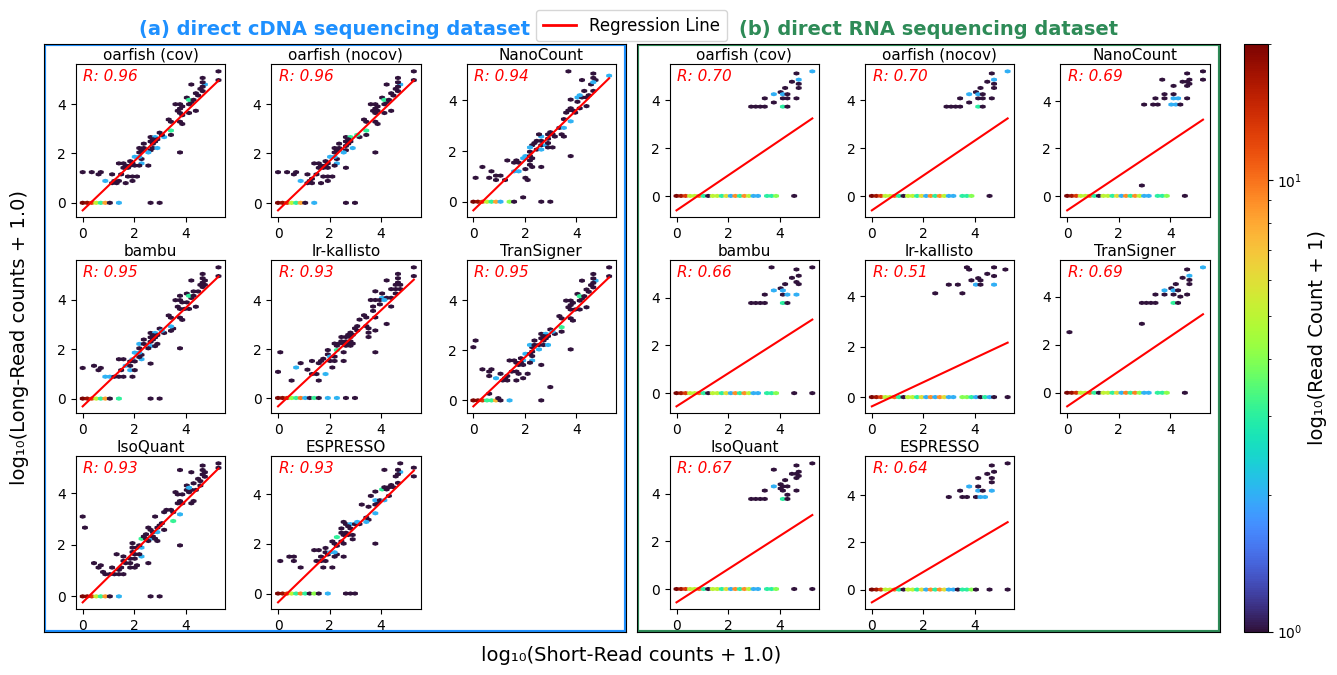

In [7]:
fig_path = '/mnt/scratch2/zahra/oarfish-paper-scripts/analysis_jupyter_notebook/figures/exp_data/hct116/sequinTxp/density_plot.jpg'

# Create the figure and define the layout
fig = plt.figure(figsize=(12, 6))  # Width = 12 inches, Height = 8 inches

# Adjust the overall margins of the figure
fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)  # Overall figure spacing

# Create the outer grid with space between main plots
gs = fig.add_gridspec(1, 2, wspace=0.02)

titles = ['(a) direct cDNA sequencing dataset', '(b) direct RNA sequencing dataset']
datasets = ["directcDNA", "directRNA"]
colors = ["lightcyan", "honeydew"]
textcolors = ["dodgerblue", "seagreen"]

# Iterate through main plots and add inner grids with padding
for i, (title, data, color_val, t_color) in enumerate(zip(titles, datasets, colors, textcolors)):
    ax = fig.add_subplot(gs[0, i])
    ax.set_title(title, fontsize=14, fontweight='bold', color=t_color)  # Customize title font
    
    # Define the inner gridspec within each main plot area with increased spacing
    gs_inner = gs[0, i].subgridspec(3, 3, wspace=0.02, hspace=0.0)  # Controls spacing between inner subplots
    
    for j, method_name in enumerate(method_names):
        row = j // 3
        col = j % 3
        sub_ax = fig.add_subplot(gs_inner[row, col])
    
        illumina_value = np.log10(Quant_sequin[data]["SHORT_READ"] + 1.0)
        ont_value = np.log10(Quant_sequin[data][method_name] + 1.0)
    
        # Create a hexbin plot
        hb = sub_ax.hexbin(illumina_value, ont_value, gridsize=(30, 30), cmap='turbo', bins='log', mincnt=1)
    
        # Calculate Pearson correlation coefficient and p-value
        r_value, p_value = pearsonr(illumina_value, ont_value)
    
        # Fit a linear regression line
        slope, intercept = np.polyfit(illumina_value, ont_value, 1)
    
        # Add the regression line
        x_values = np.linspace(np.min(illumina_value), np.max(illumina_value), 100)
        y_values = slope * x_values + intercept
        sub_ax.plot(x_values, y_values, color='red', label=f'Regression Line')
    
        # Add method name bar at the top of each plot
        text_x = 0.05
        text_y = 0.97
        
        sub_ax.text(
            text_x, text_y, f'R: {r_value:.2f}', ha='left', va='top', transform=sub_ax.transAxes,
            fontsize=11, fontstyle='italic', color='red'
        )
        ## Manually draw an underline just below the text
        #sub_ax.plot(
        #    [text_x, text_x + 0.35], [text_y - 0.11, text_y - 0.11],  # Adjust length and vertical position
        #    transform=sub_ax.transAxes, color='red', lw=1.5
        #)
        sub_ax.text(0.5, 1.06, method_name, ha='center', va='center', transform=sub_ax.transAxes, bbox=dict(facecolor="none", edgecolor='none', boxstyle='round,pad=0.2', alpha=0.5), fontsize=11)
        
        # Display the legend
        #sub_ax.legend(fontsize=10)
        
        # Add an empty boundary around each inner subplot
        sub_ax.set_position([sub_ax.get_position().x0 + 0.027,  # Adjust x position slightly
                             sub_ax.get_position().y0 + 0.037,  # Adjust y position slightly
                             sub_ax.get_position().width * 0.78,  # Adjust width
                             sub_ax.get_position().height * 0.78])  # Adjust height
        
    # Add a rectangle patch to each main subplot
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,  # Offset for padding
        linewidth=3, edgecolor=t_color, facecolor="none"
    )
    ax.add_patch(rect)
    ax.set_xticks([]) 
    ax.set_yticks([])
    
# Create a fake line for the legend (without plotting it directly in the subplots)
red_line = plt.Line2D([], [], color='red', lw=2, label='Regression Line')

# Add the legend above the two main figures
fig.legend(handles=[red_line], loc='upper center', bbox_to_anchor=(0.5, 1.06), fontsize=12, ncol=1)

# Add common colorbar
cb_ax = fig.add_axes([1.01, 0.01, 0.02, 0.98])  # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cb_ax, cmap="turbo")
cb.set_label('log₁₀(Read Count + 1)', fontsize=14)

# Set common x and y labels for the entire figure, if needed
fig.text(0.5, -0.03, 'log₁₀(Short-Read counts + 1.0)', ha='center', va='center', fontsize=14, color='black')
fig.text(-0.01, 0.5, 'log₁₀(Long-Read counts + 1.0)', ha='center', va='center', rotation='vertical', fontsize=14, color='black')

# Adjust layout to make sure everything fits well
plt.tight_layout()
# Save the figure as a JPEG file
directory = os.path.dirname(fig_path)
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(fig_path, format='jpg', dpi=300, bbox_inches='tight')
plt.show()


/mnt/scratch2/zahra/tmp/ipykernel_4192823/173823238.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


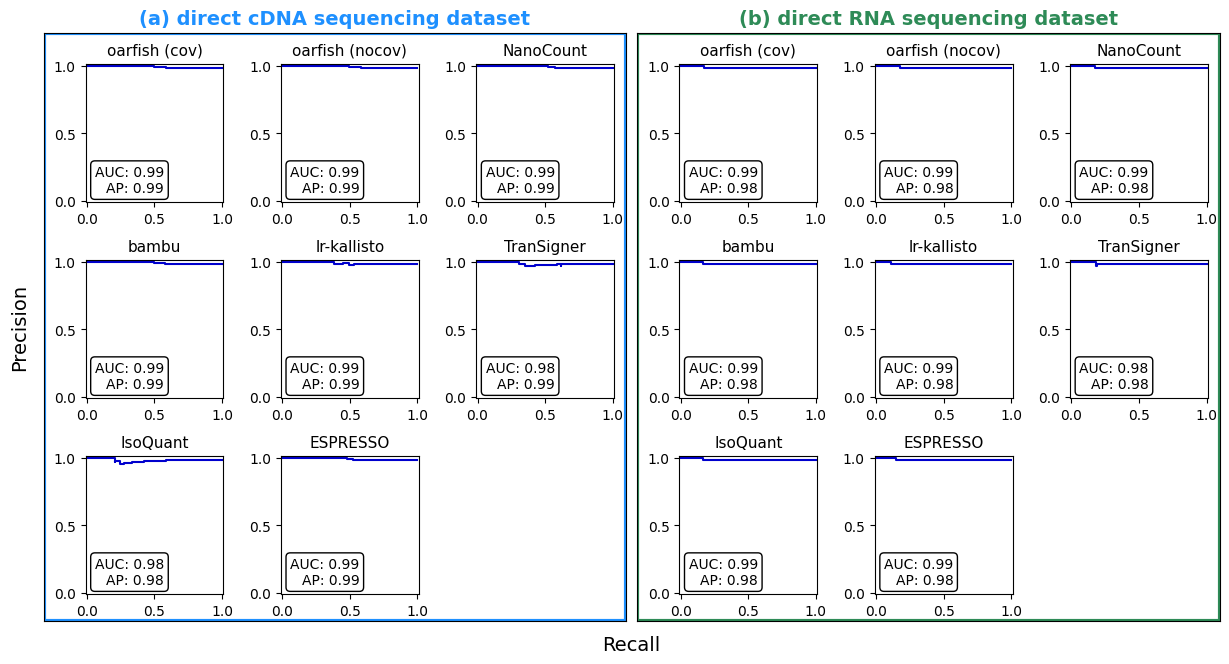

In [8]:
fig_path = '/mnt/scratch2/zahra/oarfish-paper-scripts/analysis_jupyter_notebook/figures/exp_data/hct116/sequinTxp/precision_recall.jpg'

# Create the figure and define the layout
fig = plt.figure(figsize=(12, 6))  # Width = 12 inches, Height = 8 inches

# Adjust the overall margins of the figure
fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)  # Overall figure spacing

# Create the outer grid with space between main plots
gs = fig.add_gridspec(1, 2, wspace=0.02)

titles = ['(a) direct cDNA sequencing dataset', '(b) direct RNA sequencing dataset']
datasets = ["directcDNA", "directRNA"]
colors = ["lightcyan", "honeydew"]
textcolors = ["dodgerblue", "seagreen"]

# Iterate through main plots and add inner grids with padding
for i, (title, data, color_val, t_color) in enumerate(zip(titles, datasets, colors, textcolors)):
    ax = fig.add_subplot(gs[0, i])
    ax.set_title(title, fontsize=14, fontweight='bold', color=t_color)  # Customize title font
    
    # Define the inner gridspec within each main plot area with increased spacing
    gs_inner = gs[0, i].subgridspec(3, 3, wspace=0.02, hspace=0.0)  # Controls spacing between inner subplots
    
    for j, method_name in enumerate(method_names):
        row = j // 3
        col = j % 3
        sub_ax = fig.add_subplot(gs_inner[row, col])
    
        # Ground truth (binary labels)
        true = [1 if x > 0 else 0 for x in Quant_sequin[data]["SHORT_READ"].values]
        
        # Prediction scores
        pred = Quant_sequin[data][method_name].values
    
        # Create precision-recall display
        precision, recall, _ = precision_recall_curve(true, pred)
        
        # Calculate AUC for precision-recall curve
        pr_auc = auc(recall, precision)
        
        # Calculate and display average precision score
        avg_precision = average_precision_score(true, pred)
        
        # Plot precision-recall curve using PrecisionRecallDisplay plot method
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp.plot(sub_ax, color='mediumblue', lw=1.5)
    
        # Clear individual axis labels for precision and recall
        sub_ax.set_xlabel('')  # Remove x-axis label (Recall)
        sub_ax.set_ylabel('')  # Remove y-axis label (Precision)
        
        # Add method name bar at the top of each plot
        sub_ax.text(0.5, 1.1, method_name, ha='center', va='center', transform=sub_ax.transAxes, bbox=dict(facecolor="none", edgecolor='none', boxstyle='round,pad=0.3', alpha=0.5), fontsize=11)
        
        # Add AUC to the plot
        # Add legend with AUC and avg_precision
        legend_text = f'AUC: {pr_auc:.2f}\nAP: {avg_precision:.2f}'
        sub_ax.text(0.57, 0.27, legend_text, ha='right', va='top', transform=sub_ax.transAxes, fontsize=10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
        
        # Add an empty boundary around each inner subplot
        sub_ax.set_position([sub_ax.get_position().x0 + 0.035,  # Adjust x position slightly
                             sub_ax.get_position().y0 + 0.04,  # Adjust y position slightly
                             sub_ax.get_position().width * 0.72,  # Adjust width
                             sub_ax.get_position().height * 0.72])  # Adjust height
        
    # Add a rectangle patch to each main subplot
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,  # Offset for padding
        linewidth=3, edgecolor=t_color, facecolor="none"
    )
    ax.add_patch(rect)
    ax.set_xticks([]) 
    ax.set_yticks([])
    


# Set common x and y labels for the entire figure, if needed
fig.text(0.5, -0.03, 'Recall', ha='center', va='center', fontsize=14, color='black')
fig.text(-0.01, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize=14, color='black')

# Adjust layout to make sure everything fits well
plt.tight_layout()
# Save the figure as a JPEG file
directory = os.path.dirname(fig_path)
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(fig_path, format='jpg', dpi=300, bbox_inches='tight')
plt.show()
